In [3]:
pip install pandas seaborn scikit-learn matplotlib imblearn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [6]:
train_data = pd.read_csv('../dataset/train.csv')

print("Dataset Overview:")
print(train_data.info())

print("\nUnique Values in Each Column:")
unique_values = train_data.nunique()
print(unique_values)

print("\nSample Data:")
print(train_data.head())

numerical_columns = train_data.select_dtypes(include=['float64', 'int64'])

print("\nStatistical Analysis of Numerical Columns:")
stats = numerical_columns.describe(percentiles=[0.25, 0.5, 0.75]).T
stats['std'] = numerical_columns.std()
print(stats)

stats.to_csv('numerical_column_stats.csv', index=True)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           6256 non-null   int64  
 1   Address         6256 non-null   object 
 2   Possesion       6256 non-null   object 
 3   Furnishing      6256 non-null   object 
 4   Buildup_area    6256 non-null   float64
 5   Carpet_area     6256 non-null   float64
 6   Bathrooms       6256 non-null   float64
 7   Property_age    6256 non-null   int64  
 8   Parking         6256 non-null   int64  
 9   Price           6256 non-null   int64  
 10  Brokerage       6256 non-null   float64
 11  Floor           6256 non-null   float64
 12  Per_sqft_price  6256 non-null   float64
 13  BHK             6256 non-null   float64
 14  Total_bedrooms  6256 non-null   float64
dtypes: float64(8), int64(4), object(3)
memory usage: 733.3+ KB
None

Unique Values in Each Column:
index     


Correlation with Target Variable:
index             0.053619
Buildup_area      0.840860
Carpet_area       0.895774
Bathrooms         0.359334
Property_age      0.069613
Parking           0.509753
Price             1.000000
Brokerage         0.671218
Floor             0.293367
Per_sqft_price    0.751061
BHK               0.681427
Total_bedrooms    0.670491
Name: Price, dtype: float64

Columns to Drop Due to Weak Correlation:
Index(['index', 'Property_age'], dtype='object')
Column 'index' was dropped due to weak correlation (0.05) with 'Price'.
Column 'Property_age' was dropped due to weak correlation (0.07) with 'Price'.

Processed train data saved to: dropped_cols_train_data.csv


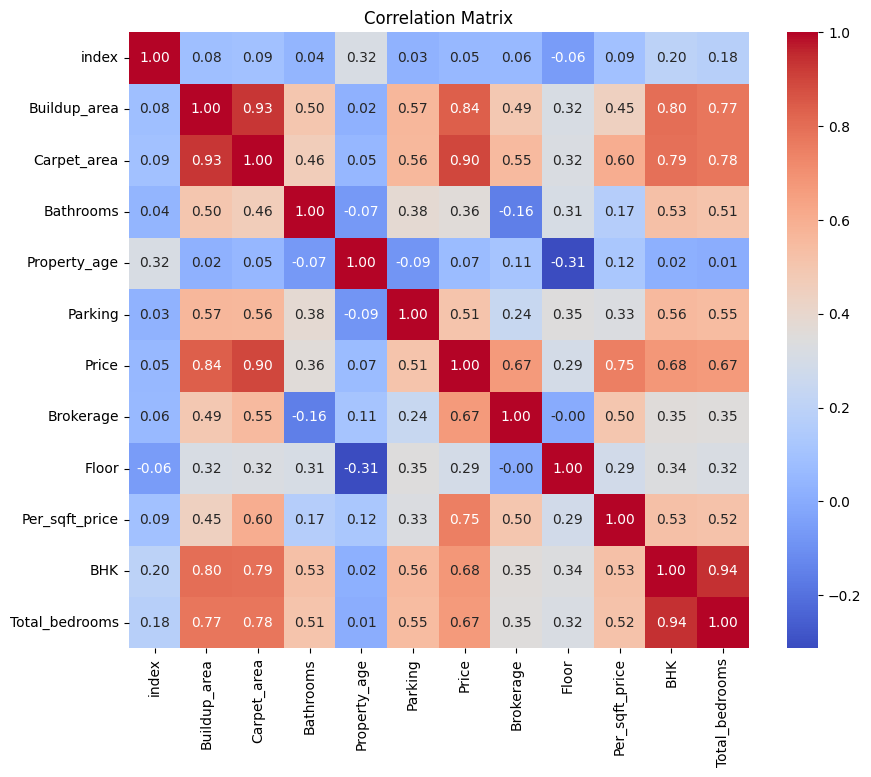

In [7]:
numerical_data = train_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

if 'Price' in correlation_matrix.columns:
    target_correlation = correlation_matrix['Price']
    print("\nCorrelation with Target Variable:")
    print(target_correlation)

    weak_correlation_columns = target_correlation[(target_correlation > -0.1) & (target_correlation < 0.1)].index
    print("\nColumns to Drop Due to Weak Correlation:")
    print(weak_correlation_columns)

    train_data = train_data.drop(columns=weak_correlation_columns)

    for column in weak_correlation_columns:
        print(f"Column '{column}' was dropped due to weak correlation ({target_correlation[column]:.2f}) with 'Price'.")
else:
    print("Target variable 'Price' is not found in the correlation matrix.")

dropped_cols_data_path = "dropped_cols_train_data.csv"
train_data.to_csv(dropped_cols_data_path, index=False)
print(f"\nProcessed train data saved to: {dropped_cols_data_path}")

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")

output_path = "Plots/correlation_matrix.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In [8]:
# Here, we assume that all the columns with 'object' data type are categorical columns, including "Address"
categorical_columns = train_data.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

label_encoder = LabelEncoder()

for col in categorical_columns:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    print(f"Column '{col}' encoded with Label Encoding.")

print("\nTransformed Dataset (with Encoded Categorical Columns):")
print(train_data.head())

Categorical Columns: Index(['Address', 'Possesion', 'Furnishing'], dtype='object')
Column 'Address' encoded with Label Encoding.
Column 'Possesion' encoded with Label Encoding.
Column 'Furnishing' encoded with Label Encoding.

Transformed Dataset (with Encoded Categorical Columns):
   Address  Possesion  Furnishing  Buildup_area  Carpet_area  Bathrooms  \
0      183          0           1         615.0   508.043150        1.0   
1       15          0           1        1200.0   724.772558        3.0   
2     3106          0           1        3300.0  2300.000000        5.0   
3     1478          0           2         800.0   642.570682        1.0   
4      305          0           1        2000.0  1602.321210        4.0   

   Parking      Price   Brokerage  Floor  Per_sqft_price  BHK  Total_bedrooms  
0        0   14500000  14500000.0    7.0         23580.0  2.0             2.0  
1        1   18500000  18500000.0   13.0         15420.0  2.0             2.0  
2        3  125000000   12

In [9]:
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns


# I decided to do the analysis here itself on training Decision Tree on scaled and unscaled data

# Training Decision Tree on unscaled data
X_unscaled = train_data.drop(columns=['Price'])
y_unscaled = train_data['Price']
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_unscaled, y_unscaled, test_size=0.2, random_state=42)

model_unscaled = DecisionTreeRegressor(random_state=42)
model_unscaled.fit(X_train_unscaled, y_train_unscaled)

y_pred_unscaled = model_unscaled.predict(X_test_unscaled)
mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
print(f"\nMean Squared Error (Unscaled Data): {mse_unscaled}")


# Scaling the numerical columns
scaler = StandardScaler()

scaled_features = scaler.fit_transform(train_data[numerical_columns])

train_data[numerical_columns] = scaled_features

print("\nScaled Numerical Features:")
print(train_data[numerical_columns].head())

# Training Decision Tree on scaled data
X_scaled = train_data.drop(columns=['Price'])
y_scaled = train_data['Price']
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

model_scaled = DecisionTreeRegressor(random_state=42)
model_scaled.fit(X_train_scaled, y_train_scaled)

y_pred_scaled = model_scaled.predict(X_test_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"Mean Squared Error (Scaled Data): {mse_scaled}")


Mean Squared Error (Unscaled Data): 34382255280351.438

Scaled Numerical Features:
    Address  Possesion  Furnishing  Buildup_area  Carpet_area  Bathrooms  \
0 -1.528569        0.0   -0.382529     -0.687932    -0.611804  -1.061809   
1 -1.712457        0.0   -0.382529      0.107891    -0.240206   1.131881   
2  1.670861        0.0   -0.382529      2.964691     2.460628   3.325572   
3 -0.111100        0.0    1.076678     -0.436261    -0.381147  -1.061809   
4 -1.395032        0.0   -0.382529      1.196196     1.264411   2.228726   

    Parking     Price  Brokerage     Floor  Per_sqft_price       BHK  \
0 -1.628459 -0.424235   0.095406 -0.923674        0.012601 -0.159218   
1 -0.374441 -0.318695   0.221827 -0.493578       -0.611908 -0.159218   
2  2.133594  2.491333  -0.323364  0.868393        1.107023  1.836910   
3 -0.374441 -0.384658   0.142814 -1.138723       -0.261387 -0.159218   
4  0.879576  1.435924   2.323578 -0.565261        1.460605  0.838846   

   Total_bedrooms  
0     

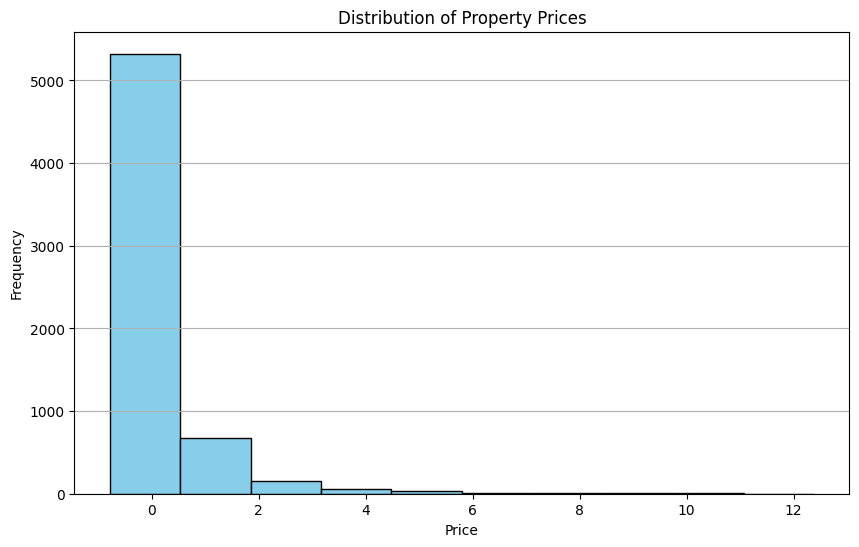

      Price Price_Category
0 -0.424235         Medium
1 -0.318695         Medium
2  2.491333      Very High
3 -0.384658         Medium
4  1.435924      Very High


C:\Users\vikra\AppData\Local\Temp\ipykernel_38360\515696601.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


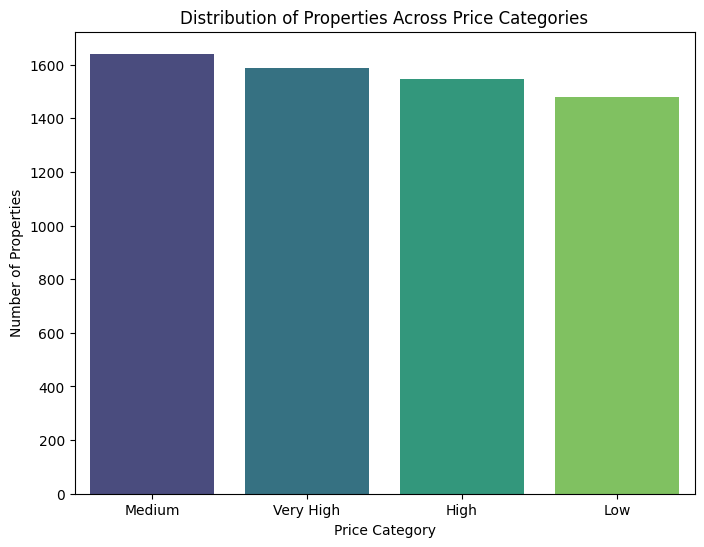


Distribution of Properties Across Price Categories:
Price_Category
Medium       1641
Very High    1589
High         1545
Low          1481
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(10, 6))
plt.hist(train_data['Price'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y')

output_path = "Plots/price_distribution.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

def categorize_price(price):
    if price < train_data['Price'].quantile(0.25):
        return 'Low'
    elif price < train_data['Price'].quantile(0.5):
        return 'Medium'
    elif price < train_data['Price'].quantile(0.75):
        return 'High'
    else:
        return 'Very High'

train_data['Price_Category'] = train_data['Price'].apply(categorize_price)

print(train_data[['Price', 'Price_Category']].head())

category_counts = train_data['Price_Category'].value_counts()

# Plot the distribution of price categories
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Properties Across Price Categories')
plt.xlabel('Price Category')
plt.ylabel('Number of Properties')

output_path = "Plots/price_category_distribution.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print("\nDistribution of Properties Across Price Categories:")
print(category_counts)

Original Training Set Distribution:
Price_Category
Medium       1312
Very High    1271
High         1236
Low          1185
Name: count, dtype: int64

Distribution After Random Undersampling:
Price_Category
High         1185
Low          1185
Medium       1185
Very High    1185
Name: count, dtype: int64

Distribution After Random Oversampling:
Price_Category
Low          1312
Medium       1312
High         1312
Very High    1312
Name: count, dtype: int64


C:\Users\vikra\AppData\Local\Temp\ipykernel_38360\1373968550.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_under.value_counts().index, y=y_train_under.value_counts().values, palette='viridis')


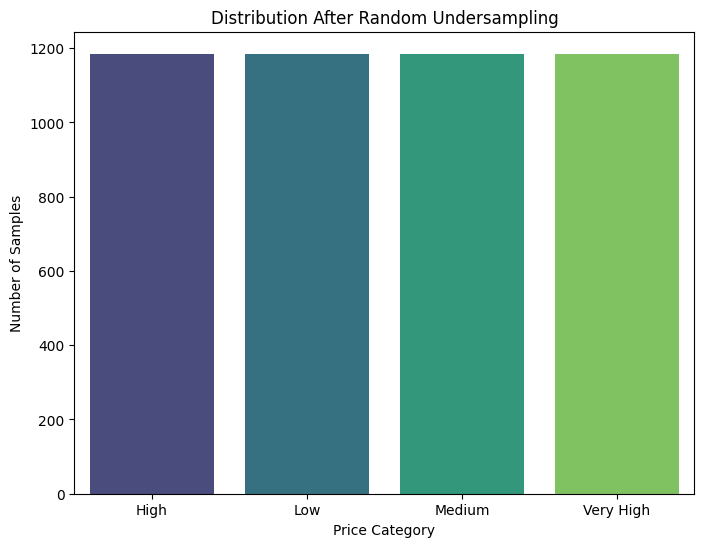

C:\Users\vikra\AppData\Local\Temp\ipykernel_38360\1373968550.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_train_over.value_counts().index, y=y_train_over.value_counts().values, palette='viridis')


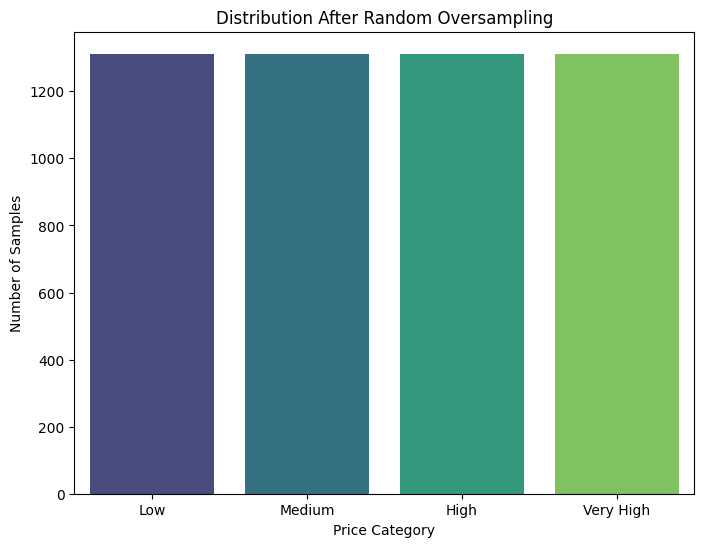

In [11]:
X = train_data.drop(columns=['Price', 'Price_Category', 'Address', 'Possesion', 'Furnishing'])
y = train_data['Price_Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Original Training Set Distribution:")
print(y_train.value_counts())

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

undersampled_data = pd.concat([X_train_under, y_train_under], axis=1)
undersampled_data.to_csv('undersampled_data.csv', index=False)

print("\nDistribution After Random Undersampling:")
print(y_train_under.value_counts())

# Apply oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

oversampled_data = pd.concat([X_train_over, y_train_over], axis=1)
oversampled_data.to_csv('oversampled_data.csv', index=False)

print("\nDistribution After Random Oversampling:")
print(y_train_over.value_counts())

plt.figure(figsize=(8, 6))
sns.barplot(x=y_train_under.value_counts().index, y=y_train_under.value_counts().values, palette='viridis')
plt.title('Distribution After Random Undersampling')
plt.xlabel('Price Category')
plt.ylabel('Number of Samples')

output_path = "Plots/undersampling_price_category_distribution.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x=y_train_over.value_counts().index, y=y_train_over.value_counts().values, palette='viridis')
plt.title('Distribution After Random Oversampling')
plt.xlabel('Price Category')
plt.ylabel('Number of Samples')

output_path = "Plots/oversampling_price_category_distribution.png"
plt.savefig(output_path, bbox_inches='tight')
plt.show()